# Presentation of DBSCAN Clustering
This is a walk though of our clustering algorithm. \
To get the presentation to work you need the latest version of 'scanpy_clustering' (our package), 'scanpy' and 'anndata'.

In [12]:
# Core scverse libraries
import importlib
import scanpy as sc
import anndata as ad
import scanpy_clustering.clustering as cl
importlib.reload(cl)

<module 'scanpy_clustering.clustering' from 'C:\\Users\\valde\\OneDrive - Danmarks Tekniske Universitet\\4 semester\\Fagprojekt\\Git\\enhanced-scanpy-clustering\\scanpy_clustering\\clustering.py'>

## Loading in the data
The data is in the 'tests' folder

In [13]:
# Update the path to the correct location of your .h5ad file
adata = sc.read_h5ad('symsim_observed_counts_5000genes_5000cells_complex.h5ad')
adata

AnnData object with n_obs × n_vars = 5000 × 5000
    obs: 'group'
    var: 'col.names'

In the 'normal' pipeline you would now preform some Normalization, Feature Selection and some Dimensionality Reduction. We will skip this part, as it does not consern the resulting clustering. \
In the testing of our algorithms we have done these things, and found that it does not make a big differance, therefore to save some time we will skip it. 

## Visualization
To visualize the data the scanpy pipeline uses UMAP plotting.

In [14]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

c:\Users\valde\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_utils.py:40: UserWarning: You’re trying to run this on 5000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


We can now visualize the UMAP according to the `data`. 

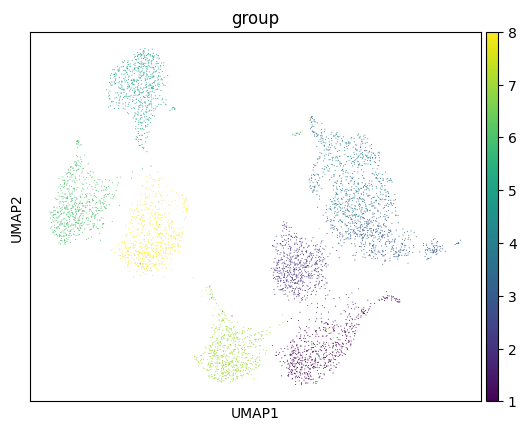

In [15]:
sc.pl.umap(
    adata,
    color="group",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

These are the 'True Groupings' of our dataset. 

## Clustering
Now we divert from the original scanpy pipeline and cluster using our clustering algorithms from the `scanpy_clustering`-package.\
\
To find the optimal `eps` we construct a k'th-NN graph. The elbow of the graph will us a good starting point to find a suitble distance.  

In [16]:
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import numpy as np

X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X  # Convert sparse if needed

# Set k (min_samples for DBSCAN, usually 4 or 5)
k = 5

# Compute k-nearest neighbors using KDTree
tree = KDTree(X)
distances, _ = tree.query(X, k=k+1)  # k+1 because first neighbor is itself

# Get the k-th nearest neighbor distance for each point
k_distances = distances[:, -1]  # Last column gives k-th neighbor distance

# Sort distances in ascending order
k_distances.sort()

# Plot k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(k_distances)), k_distances, marker='o', linestyle='-')
plt.xlabel("Data Point Index (sorted)")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.title(f"k-Distance Graph for k={k}")
plt.grid()
plt.show()

KeyboardInterrupt: 

Now we use the `eps` just found to cluster our data. 

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

cl.cluster(adata, algorithm='DBScan_Base', key_added='dbscan_labels_1', eps=1700, min_samples=100, metric='euclidean')
print(adata.obs, np.unique(adata.obs["dbscan_labels_1"]))
adjusted_rand_score(adata.obs['group'], adata.obs['dbscan_labels_1'])

      group dbscan_labels_1 dbscan_labels_2
1         1               0               0
2         1               0               0
3         1               0               0
4         1              -1               0
5         1               0               0
...     ...             ...             ...
4996      8               0               3
4997      8               0               3
4998      8               0               3
4999      8               0               3
5000      8               0               3

[5000 rows x 3 columns] ['-1' '0']


0.13604542607205602

In [44]:
cl.cluster(adata, algorithm='DBScan_Base', key_added='dbscan_labels_2', eps=0.065, min_samples=40, metric='cosine')
print(adata.obs, np.unique(adata.obs["dbscan_labels_2"]))
adjusted_rand_score(adata.obs['group'], adata.obs['dbscan_labels_2'])

      group dbscan_labels_1 dbscan_labels_2
1         1               0               0
2         1               0               0
3         1               0               0
4         1              -1               0
5         1               0               0
...     ...             ...             ...
4996      8               0               3
4997      8               0               3
4998      8               0               3
4999      8               0               3
5000      8               0               3

[5000 rows x 3 columns] ['-1' '0' '1' '2' '3' '4' '5' '6' '7']


0.2092393613786885

## Visualization of Clusterings

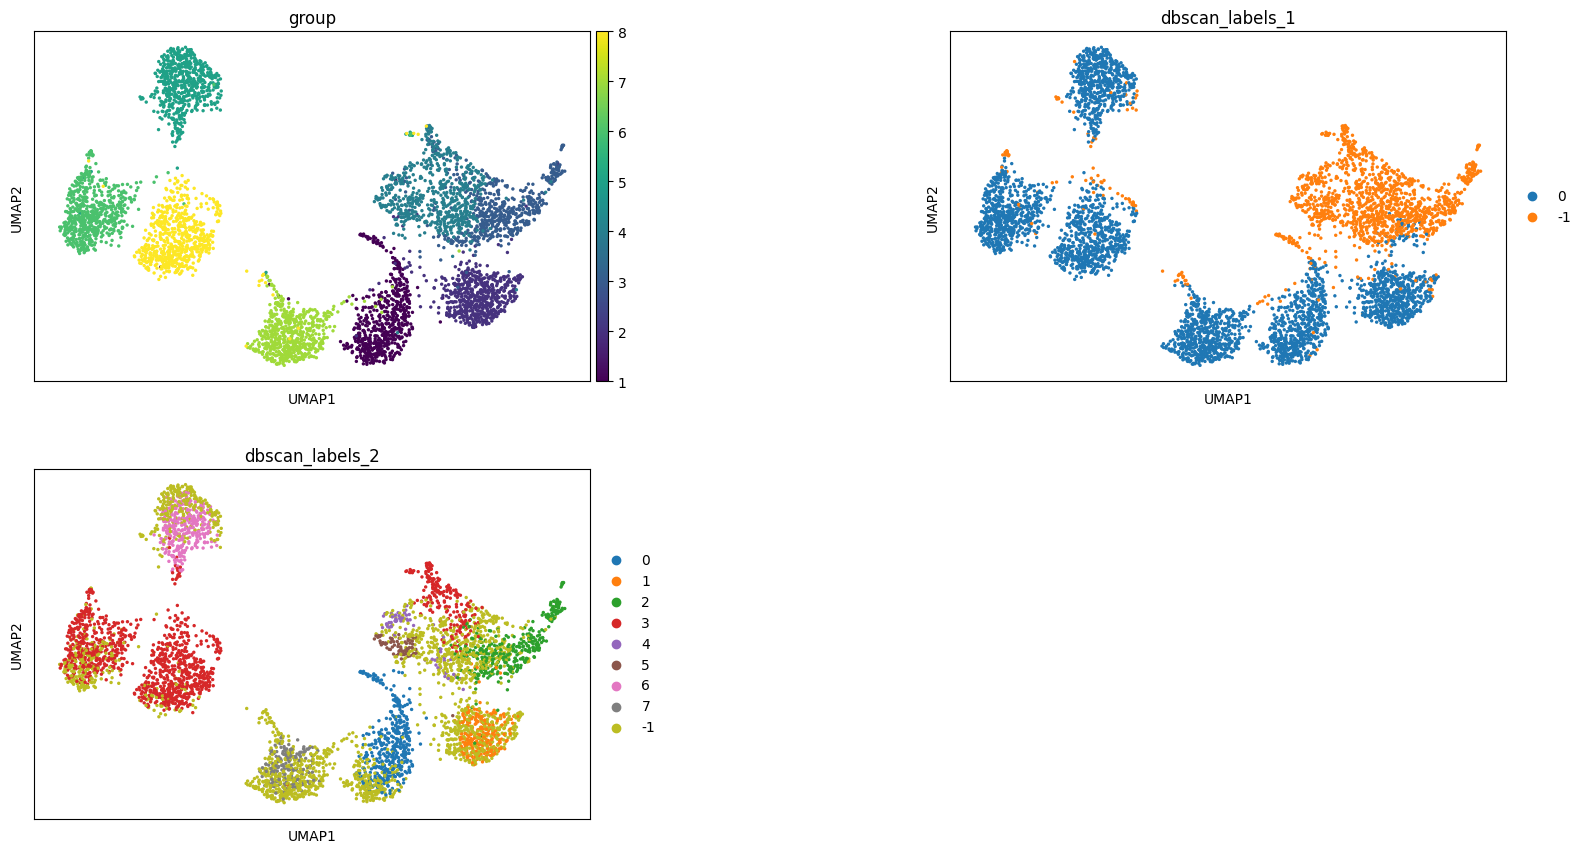

In [54]:
sc.pl.umap(
    adata,
    color=["group", "dbscan_labels_1", "dbscan_labels_2"],
    wspace=0.5,
    ncols=2,
)